In [17]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StringIndexerModel
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import when, col
import numpy as np

In [6]:
# Initialize Spark session
spark = SparkSession.builder.appName("logistic_regression").getOrCreate()

# Let's assume 'df' is your original DataFrame and 'isMoA' is your label column
df = spark.read.parquet("data/analysis/biodata_all_v2", header=True, inferSchema=True)

In [7]:
df = df.fillna({"proteinClass": "Unknown"})

In [8]:
# Mark non-null values in 'sources' as Important/Not_Important
df = df.withColumn("sources_imp", when(col("sources").isNotNull(), "Important").otherwise("Not_Important"))

In [9]:
# Drop existing columns if they exist
for col_name in ['proteinClassIndex', 'proteinClassVec', 'sourcesIndex', 'sourcesVec']:
    if col_name in df.columns:
        df = df.drop(col_name)

In [10]:
# Define StringIndexer and OneHotEncoder stages for 'proteinClass' and 'sources_imp'
protein_indexer = StringIndexer(inputCol="proteinClass", outputCol="proteinClassIndex", handleInvalid="keep")
sources_indexer = StringIndexer(inputCol="sources_imp", outputCol="sourcesIndex", handleInvalid="keep")

protein_encoder = OneHotEncoder(inputCol="proteinClassIndex", outputCol="proteinClassVec")
sources_encoder = OneHotEncoder(inputCol="sourcesIndex", outputCol="sourcesVec")

# VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=["pchembl_value", "proteinClassVec", "sourcesVec"], outputCol="features")

# Convert the target column to numeric (assuming it's boolean)
df = df.withColumn("label", col("isMoA").cast("double"))

# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.7, 0.3])

In [11]:
# Define the LogisticRegression estimator
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Define the Pipeline which consists of all the stages
pipeline = Pipeline(stages=[protein_indexer, sources_indexer, protein_encoder, sources_encoder, assembler, lr])

# Fit the pipeline on the training data
pipeline_model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = pipeline_model.transform(test_data)

23/11/03 13:49:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/11/03 13:49:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/03 13:49:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [14]:
from pyspark.ml.linalg import Vectors
import numpy as np

# Assuming 'pipeline_model' is the fitted PipelineModel object from the previous step

# Extract LogisticRegressionModel from the fitted pipeline
lr_model = pipeline_model.stages[-1]

# Extract coefficients from the LogisticRegressionModel
coefficients = lr_model.coefficients

# Convert Spark DenseVector to numpy array
coefficients_array = np.array(coefficients)

# Exponentiate the coefficients to get the odds ratios
odds_ratios = np.exp(coefficients_array)

# Print the odds ratios for each feature
for i, odds_ratio in enumerate(odds_ratios):
    print(f"Odds ratio for feature {i} = {odds_ratio}")

Odds ratio for feature 0 = 1.877476533607761
Odds ratio for feature 1 = 0.7076776079119121
Odds ratio for feature 2 = 1.162040668848281
Odds ratio for feature 3 = 1.5172020339539933
Odds ratio for feature 4 = 0.6874567556121526
Odds ratio for feature 5 = 0.7719439234538983
Odds ratio for feature 6 = 4.041228347069181
Odds ratio for feature 7 = 1.629721922127416
Odds ratio for feature 8 = 1.2550303284017066
Odds ratio for feature 9 = 0.22808535584822315
Odds ratio for feature 10 = 4.6201698357686086e-17
Odds ratio for feature 11 = 0.010991804200473678
Odds ratio for feature 12 = 0.01343179462245936
Odds ratio for feature 13 = 31.55330230226572
Odds ratio for feature 14 = 0.03169240387009305


Area under ROC = 0.8686672375342787


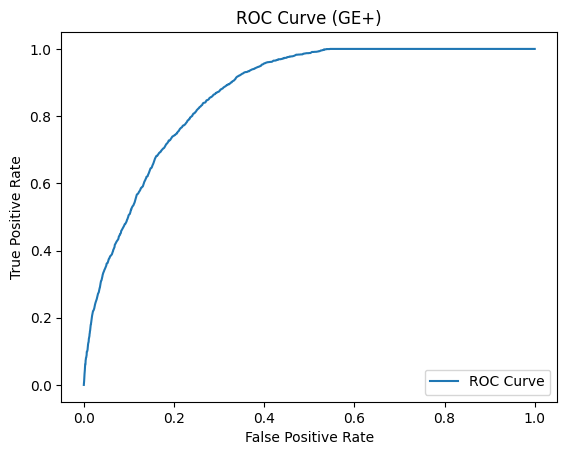

In [15]:
# Compute the AUC-ROC
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler

evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"Area under ROC = {roc_auc}")

# Plot the ROC curve
roc = lr_model.summary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'], label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (GE+)')
plt.legend(loc='lower right')
plt.show()